In [1]:
#read file with rasterio
import rasterio

file = rasterio.open("../data/CHN_carbon_grid.tif")

In [11]:
#get rasterio object extent
extent = file.bounds
print(extent)
#get rasterio object crs
crs = file.crs
print(crs)
print(crs.to_epsg())

BoundingBox(left=651596.1239194451, bottom=4538281.612483293, right=671896.1239194451, top=4560081.612483293)
PROJCS["NAD_1983_UTM_Zone_18N",GEOGCS["NAD83",DATUM["North American Datum 1983",SPHEROID["GRS 1980",6378137,298.257222101004]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-75],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
None


ERROR 1: PROJ: internal_proj_identify: /opt/anaconda3/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 2 whereas a number >= 3 is expected. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_identify: /opt/anaconda3/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 2 whereas a number >= 3 is expected. It comes from another PROJ installation.


In [10]:
#get crs info in epsg code
print(crs.to_epsg())

#original extent is not in wgs84
#reproject extent from UTM Zone 18N projected coordinate system based on the NAD83 datum to wgs84
from pyproj import Transformer
transformer = Transformer.from_crs("EPSG:26918", "EPSG:4326")
minx, miny = transformer.transform(extent.left, extent.bottom)
maxx, maxy = transformer.transform(extent.right, extent.top)
print(minx, miny, maxx, maxy)


None
40.9816306690251 -73.19800491026886 41.173859013488446 -72.95075142625052


ERROR 1: PROJ: internal_proj_identify: /opt/anaconda3/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 2 whereas a number >= 3 is expected. It comes from another PROJ installation.


In [ ]:

!gdalwarp -s_srs EPSG:26918 -t_srs EPSG:4326 ../data/CHN_carbon_grid.tif ../data/CHN_carbon_grid_wgs84.tif

In [ ]:
import rasterio
file = rasterio.open("../data/CHN_carbon_grid_wgs84.tif")
#get rasterio object extent
extent = file.bounds
print(extent)
#get rasterio object crs
crs = file.crs
print(crs)
print(crs.to_epsg())

BoundingBox(left=-73.19800491026886, bottom=40.9774554140532, right=-72.95081219502039, top=41.177910010872345)
GEOGCS["WGS 84",DATUM["World Geodetic System 1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST]]
None


ERROR 1: PROJ: internal_proj_identify: /opt/anaconda3/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 2 whereas a number >= 3 is expected. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_identify: /opt/anaconda3/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 2 whereas a number >= 3 is expected. It comes from another PROJ installation.


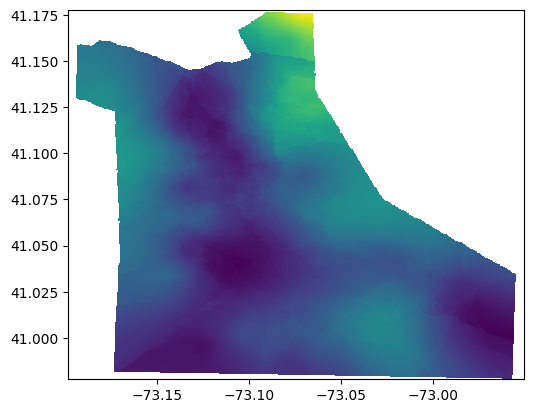

<Axes: >

In [10]:
#draw file with rasterio.plot
from rasterio.plot import show
show(file)

In [32]:
import json
#get bbox of 41,-73.5,41.1,-73.2
from shapely.geometry import box
bbox = box(-73.15, 41, -73.00, 41.05)
bbox = box(-73, 41, -74, 42)
print(bbox) 

#trim file by bbox
from rasterio.mask import mask
import geopandas as gpd
geo = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs="EPSG:4326")
coords = [json.loads(geo.to_json())['features'][0]['geometry']]
out_img, out_transform = mask(file,  coords, crop=True, pad=False,invert=False)
#fix RuntimeWarning: overflow encountered in cast A_scaled /= ((a_max - a_min) / frac)
import numpy as np
#out_img = np.where(out_img > 1e10, file.nodata, out_img).astype(file.dtypes[0])
out_meta = file.meta.copy()
out_meta.update({"driver": "GTiff",
                 "height": out_img.shape[1],
                 "width": out_img.shape[2],
                 "transform": out_transform,
                 "crs": "EPSG:4326"}
                )
with rasterio.open("../data/CHN_carbon_grid_wgs84_trimmed.tif", "w", **out_meta) as dest:
    dest.write(out_img)
    
#plot trimmed file
show(out_img, transform=out_transform, cmap='terrain',contour=True)
out_img


POLYGON ((-74 41, -74 42, -73 42, -73 41, -74 41))


CRSError: The EPSG code is unknown. PROJ: internal_proj_create_from_database: /opt/anaconda3/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 2 whereas a number >= 3 is expected. It comes from another PROJ installation.